In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(pyqg.__version__)

0.7.3.dev18


In [3]:
help(pyqg.QGModel)

Help on class QGModel in module pyqg.qg_model:

class QGModel(pyqg.qg_diagnostics.QGDiagnostics)
 |  QGModel(beta=1.5e-11, rd=15000.0, delta=0.25, H1=500, U1=0.025, U2=0.0, **kwargs)
 |
 |  Two layer quasigeostrophic model.  FJP
 |
 |  This model is meant to representflows driven by baroclinic instabilty of a
 |  base-state shear :math:`U_1-U_2`. The upper and lower
 |  layer potential vorticity anomalies :math:`q_1` and :math:`q_2` are
 |
 |  .. math::
 |
 |      q_1 &= \nabla^2\psi_1 + F_1(\psi_2 - \psi_1) \\
 |      q_2 &= \nabla^2\psi_2 + F_2(\psi_1 - \psi_2)
 |
 |  with
 |
 |  .. math::
 |      F_1 &\equiv \frac{k_d^2}{1 + \delta^2} \\
 |      F_2 &\equiv \delta F_1 \ .
 |
 |  The layer depth ratio is given by :math:`\delta = H_1 / H_2`.
 |  The total depth is :math:`H = H_1 + H_2`.
 |
 |  The background potential vorticity gradients are
 |
 |  .. math::
 |
 |      \beta_1 &= \beta + F_1(U_1 - U_2) \\
 |      \beta_2 &= \beta - F_2( U_1 - U_2) \ .
 |
 |  The evolution equations fo

In [7]:
%%time
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.50e-04, CFL: 0.047


CPU times: user 1min 10s, sys: 2min 12s, total: 3min 23s
Wall time: 17.5 s


In [3]:
%%time
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.00e-04, CFL: 0.217


CPU times: user 11min 36s, sys: 17min 5s, total: 28min 41s
Wall time: 4min 31s


In [4]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

In [5]:
%%time
smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.70e-04, CFL: 0.039


CPU times: user 3min 41s, sys: 6min 51s, total: 10min 33s
Wall time: 51.2 s


In [6]:
%%time
backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.91e-04, CFL: 0.056


CPU times: user 3min 41s, sys: 6min 58s, total: 10min 40s
Wall time: 53.4 s


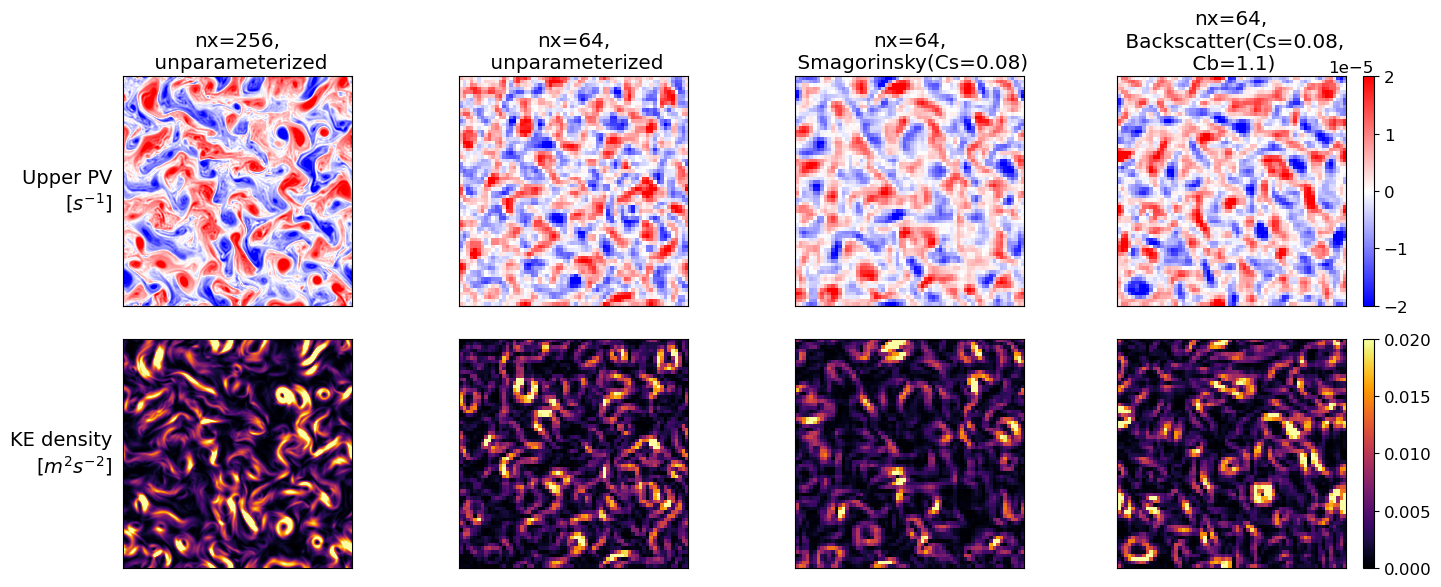

In [7]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
vlim = 2e-5
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+1, title=label_for(sim).replace(',',",\n").replace('Biharmonic',''))
    plt.imshow(sim.q[0], vmin=-vlim, vmax=vlim, cmap='bwr')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("Upper PV\n[$s^{-1}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

vlim = 2e-2
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+5)
    plt.imshow((sim.u**2 + sim.v**2).sum(0), vmin=0, vmax=vlim, cmap='inferno')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("KE density\n[$m^2 s^{-2}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

plt.tight_layout()